# Load Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

# replicates correlation

## promoter signal scan

In [4]:
import subprocess
def load_data(file_pairs,src_dir='',dst_dir='.'):
    import os
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    for file_pair in file_pairs:
        src = os.path.expanduser(os.path.join(src_dir,file_pair[0]))
        dst = os.path.expanduser(os.path.join(dst_dir,file_pair[1]))
        if os.path.isfile(dst):
            os.remove(dst)
        if not os.path.islink(dst):
            os.symlink(src,dst)

file_pairs = [['danRer11_2.ensGene.genePredExt','danRer11_2.ensGene.genePredExt']]
load_data(file_pairs,src_dir='~/source/bySpecies/danRer11_2/')
cmd = f'''awk '{{if($3=="+") print $2"\\t"$4-2000"\\t"$4+2000"\\t"$1"\\t0\\t+"; else print $2"\\t"$5-2001"\\t"$5+1999"\\t"$1"\\t0\\t-"}}' danRer11_2.ensGene.genePredExt | awk '{{if($2<0) print $1"\t0\t"$3"\t"$4"\t"$5"\t"$6; else print $0}}' | grep ^chr > danRer11_2.ensGene.promoter.bed'''
print(subprocess.check_output(cmd,shell=True).decode(),end='')




In [5]:
!wc -l danRer11_2.ensGene.promoter.bed

65840 danRer11_2.ensGene.promoter.bed


In [6]:
danRer11_promoter = pd.read_csv('danRer11_2.ensGene.promoter.bed',sep='\t',header=None,names=['chrom','start','end','name','score','strand'])
seen, duplicate = [], []
for index, row in danRer11_promoter.iterrows():
    if row['name'] in seen:
        duplicate.append(row['name'])
    else:
        seen.append(row['name'])
danRer11_promoter.loc[[True if x not in duplicate else False for x in danRer11_promoter['name']],:].to_csv('danRer11_2.ensGene.promoter.bed',sep='\t',header=None,index=None)


In [7]:
bw_scan = False

import os
import subprocess
import gzip
import seaborn as sns


def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean', shell=True).decode()
    fold = float(fold.split()[1])
    return fold


promoter_file = 'danRer11_2.ensGene.promoter.bed'
signal = pd.DataFrame(index=pd.read_csv(promoter_file,sep='\t',header=None)[3])

for sample in sample_list:
    bw_scan_cmd = f'bigWigAverageOverBed {sample}.bw {promoter_file} danRer11_2_promoter_{sample}.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(),end='')
    bw_mean = get_bigwig_mean(f'{sample}.bw')
    signal[sample] = pd.read_csv(f'danRer11_2_promoter_{sample}.tsv',sep='\t',header=None,names=['name','size','covered','sum','mean0','mean'],index_col=0)['mean0'] / bw_mean

signal.head()

,Nanog_256_rep1,Nanog_256_rep2,Nanog_256_rep3,Nanog_1k_rep1,Nanog_1k_rep2,Nanog_1k_rep3,Nanog_dome_rep1,Nanog_dome_rep2,Nanog_dome_rep3,Pou5f3_dome_rep1,Pou5f3_dome_rep2,Pou5f3_dome_rep3,Sox19b_dome_rep1,Sox19b_dome_rep2,Sox19b_dome_rep3
3,,,,,,,,,,,,,,,
ENSDART00000164359.1,0.921801,0.833203,1.843285,1.764561,1.785685,1.264008,2.152083,1.784591,2.131418,0.935137,1.368905,2.016643,1.014965,1.439107,1.390344
ENSDART00000158290.1,1.382703,1.123560,0.571310,0.657041,1.086780,0.718933,0.286467,0.589314,0.426284,0.928818,1.130833,1.008321,0.477630,0.875977,0.544512
ENSDART00000157701.1,1.382703,1.679029,1.559425,1.483286,1.395979,0.897491,1.160191,0.892295,1.278850,0.827723,1.666493,1.609123,0.716447,1.159726,1.075259
ENSDART00000167898.1,0.921801,0.833203,1.843285,1.815104,1.862526,1.264008,2.331127,1.638095,2.131418,0.928818,1.386900,2.016643,0.964218,1.385268,1.454586
ENSDART00000166393.1,0.921801,0.833203,1.843285,1.815104,1.862526,1.264008,2.331127,1.638095,2.131418,0.777173,1.368905,1.858292,1.014965,1.447840,1.390344


In [9]:
def gen():
    for sample in ['Nanog_256','Nanog_1k','Nanog_dome','Pou5f3_dome','Sox19b_dome']:
        for i in range(1,4):
            for j in range(i+1,4):
                yield sample, corr.loc[f'{sample}_rep{i}',f'{sample}_rep{j}']

corr_df = pd.DataFrame(gen(),columns=['sample','corr'])
corr_df.head()

,sample,corr
0,Nanog_256,0.999834
1,Nanog_256,0.993448
2,Nanog_256,0.992981
3,Nanog_1k,0.988693
4,Nanog_1k,0.971921


## bar plot -- Fig.S4D

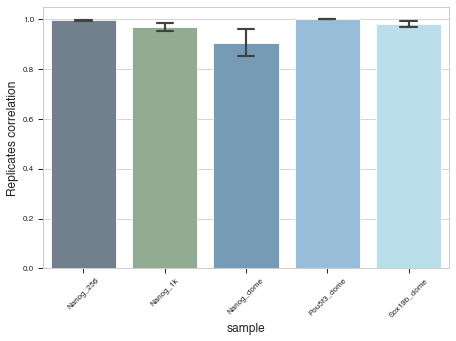

In [14]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 8,
                             'ytick.labelsize': 8,
                             'legend.fontsize': 8
                         }):
    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    sns.barplot(
        x='sample',
        y='corr',
        data=corr_df,
        palette=['#727F8D', '#92AC93', '#769BB6', '#98BDD8', '#BADEEA'],
        ci='sd',
        saturation=1,
        capsize=.2,
        ax=ax,
    )
    ax.set_xticklabels(labels=[
        'Nanog_256', 'Nanog_1k', 'Nanog_dome', 'Pou5f3_dome', 'Sox19b_dome'
    ],
                       rotation=45)
    ax.set_ylabel('Replicates correlation')
    fig.tight_layout()
    fig.savefig('Supple_Fig4D_barplot_correlation_promoter.pdf', transparent=True)

In [13]:
corr_df.groupby(by=['sample']).mean()

,corr
sample,
Nanog_1k,0.970005
Nanog_256,0.995421
Nanog_dome,0.906365
Pou5f3_dome,0.999682
Sox19b_dome,0.981680
